In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
from collections import OrderedDict
from scipy import stats
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
fsize = 10
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': fsize})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 2000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5
# Set x tick params
mpl.rcParams['xtick.major.size'] = 4.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.minor.width'] = 1.25
# Set y tick params
mpl.rcParams['ytick.major.size'] = 4.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.minor.width'] = 1.25
# Load LaTeX and amsmath
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
# All data is loaded, now compute analytical aspects
r_cut = (2.**(1./6.))

# Get lattice spacing for particle size
def ljForce(r, eps, sigma=1.):
    div = (sigma/r)
    dU = (24. * eps / r) * ((2*(div**12)) - (div)**6)
    return dU

# Lennard-Jones pressure
def ljPress(r, eps, sigma=1.):
    # Compute force
    dU = ljForce(r, eps, sigma)
    # This is just pressure divided by the area of a particle
    return (12. * dU / (np.pi * r))

def compPeNet(xf, pes, pef):
    peNet = (pes * (1.-xf)) + (pef * xf)
    return peNet
    
def avgCollisionForce(peNet):
    '''Computed from the integral of possible angles'''
#     peNetCritical = 40.
#     if peNet < peNetCritical:
#         peNet = 0
#     else:
#         peNet -= peNetCritical
    # A vector sum of the six nearest neighbors
    magnitude = np.sqrt(28)
    return (magnitude * peNet) / (np.pi)

def conForRClust(peNet, eps):
    '''Get the lattice spacing for any pe'''
    if peNet == 0:
        return 2.**(1./6.)
    out = []
    r = 2.**(1./6.)
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while ljForce(r, eps) < avgCollisionForce(peNet):
            r -= j
        r += j
    return r

def latToPhi(latIn):
    '''Read in lattice spacing, output phi'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    return phiCP / (latIn**2)

# From area fraction, get lattice spacing
def phiToLat(phiIn):
    '''Read in phi, output the lattice spacing'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    latCP = 1.
    return np.sqrt(phiCP / phiIn)

def clustFrac(phi, phiG, aF, aS, xF, sig=1.):
    '''Compute the fraction of particles in the cluster'''
    if xF == 0.:
        phiLS = latToPhi(aS)
        phiLF = 1.
    elif xF == 1.:
        phiLS = 1.
        phiLF = latToPhi(aF)
    else:
        phiLS = latToPhi(aS)
        phiLF = latToPhi(aF)
    coeff = (phiG - phi) / phi
    num = phiLF * phiLS
    den = ( phiG * ((phiLS*xF) + (phiLF*(1.-xF))) ) - (phiLF * phiLS)
    ans = coeff * num / den
    return ans

def compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05):
    '''Compute phiG from kinetic theory'''
    num = 3. * sigma * (np.pi**2) * kappa
    den = 4. * ((xF * peF) + ((1.-xF)*peS))
    coef = (xF/aF) + ((1.-xF)/aS) 
#     coef = 1 / ((aF*xF) + (aS*(1.-xF)))
    if den != 0.:
        phiG = coef * (num / den)
    else:
        phiG = phi
    if phiG > phi:
        phiG = phi
    return phiG

# Computations in terms of f*
def fStar(pe, epsilon, sigma=1.):
    out = (avgCollisionForce(pe) * sigma) / (24.*epsilon)
    return out

def nonDimFLJ(r, sigma=1.):
    div = (sigma/r)
    dU = (1. / r) * ((2*(div**12)) - (div)**6)
    return dU

def latForFStar(fstar):
    r = 1.112
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while nonDimFLJ(r) < fstar:
            r -= j
        r += j
    out = r
    return out

In [3]:
# Let's plot things and see what's happening
epsRange = [1., 0.1, 0.01, 0.001, 0.0001]
epsRange = [0.0001]
xfRange = np.arange(0.0, 1.1, 0.1)
# xfRange = [0.3, 0.5, 0.7]
# xfRange = [0.1, 0.5, 0.9]
xfRange = [0.5]
pefRange = np.arange(0.0, 501.0, 1.0)
pesRange = np.arange(0.0, 501.0, 1.0)
# pefRange = np.arange(200.0, 206.0, 0.1)
# pesRange = np.arange(0.0, 10.0, 0.01)
N = 100000.
norm = 10.**0.

phiCP = np.pi / (2. * np.sqrt(3))
phi = 0.6
lat = []
latF = []
latS = []
pLJ = []
cfs = []
Rls = []
peCrit = []
phiGs = []
phiCPs = []
peNets = []

for i in range(0, len(epsRange)):
    # Add index for this epsilon
    lat.append([])
    latF.append([])
    latS.append([])
    pLJ.append([])
    cfs.append([])
    Rls.append([])
    peCrit.append([])
    phiGs.append([])
    phiCPs.append([])
    peNets.append([])
    for j in range(0, len(xfRange)):
        # Add index for this xf
        lat[i].append([])
        latF[i].append([])
        latS[i].append([])
        pLJ[i].append([])
        cfs[i].append([])
        Rls[i].append([])
        peCrit[i].append([])
        phiGs[i].append([])
        phiCPs[i].append([])
        peNets[i].append([])
        for k in range(0, len(pefRange)):
            # Add index for this pef
            lat[i][j].append([])
            latF[i][j].append([])
            latS[i][j].append([])
            pLJ[i][j].append([])
            cfs[i][j].append([])
            Rls[i][j].append([])
            peCrit[i][j].append([])
            phiGs[i][j].append([])
            phiCPs[i][j].append([])
            peNets[i][j].append([])
            for l in range(0, len(pesRange)):
                # Get values, swap if necessary
                cpes = pesRange[l]
                cpef = pefRange[k]
                cxf = xfRange[j]
                if pesRange[l] > pefRange[k]:
                    cpes = pefRange[k]
                    cpef = pesRange[l]
                    cxf = 1. - xfRange[j]
                # Compute net activity
                peNet = compPeNet(cxf, cpes, cpef)
                peNets[i][j][k].append(peNet)
                
                # Compute lattice spacing (from pe net and individually)
                cLat = conForRClust(peNet, epsRange[i])
                sLat = conForRClust(cpes, epsRange[i])
                fLat = conForRClust(cpef, epsRange[i])
                lat[i][j][k].append(cLat)
                latF[i][j][k].append(fLat)
                latS[i][j][k].append(sLat)
                
                # Compute pressure
                cPLJ = ljPress(cLat, epsRange[i])
                pLJ[i][j][k].append(cPLJ)
                
                # Compute phiG
#                 compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05)
                cphiG = compPhiG(phi, cpes, cpef, cxf, fLat, sLat)
                phiGs[i][j][k].append(cphiG)
    
                # Compute cluster fraction
                if phiGs == phi:
                    ccf = 0.
                else:
                    ccf = clustFrac(phi, cphiG, fLat, sLat, cxf)
                if ccf < 0. or ccf > 1.:
                    ccf = 0.
                cfs[i][j][k].append(ccf)
                
                # Compute cluster size
                Nl = ccf * N
                Al = Nl * (np.pi * (cLat**2) * 0.25)
                cRl = np.sqrt(Al / (np.pi))
                Rls[i][j][k].append(cRl)
    # This is just to see how fast things are moving along
    print(i)

0


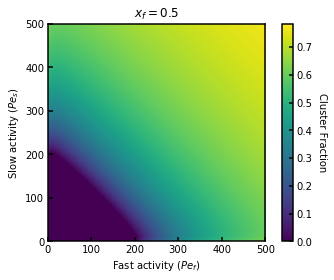

In [6]:
# Let's loop through xF to show how this effects mixtures
for z in range(0, len(xfRange)):
    # Let's look at the cluster fraction (for constant xf and epsilon)    
    pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    for k in range(0, len(pefRange)):
        for l in range(0, len(pesRange)):
            pltCF[k][l] = cfs[-1][z][k][l]
            pltPhiG[k][l] = phiGs[-1][z][k][l]
    # Plot the heatmap you've made
#     print(np.amax(pltCF))
    fig, ax = plt.subplots()
#     im = ax.imshow(pltPhiG.T, origin='lower', extent=(0., 500., 0., 500.))
    im = ax.imshow(pltCF.T, origin='lower', extent=(0., 500., 0., 500.))
    cbar = plt.colorbar(im)
    cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    ax.set_title(r'$x_{f}=$' + str(xfRange[z]))
    ax.set_xlabel(r'Fast activity $(Pe_{f})$')
    ax.set_ylabel(r'Slow activity $(Pe_{s})$')
    plt.show()
        

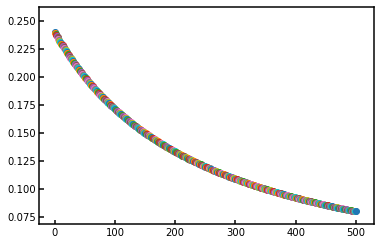

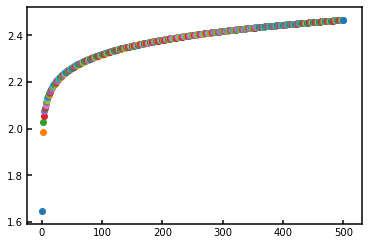

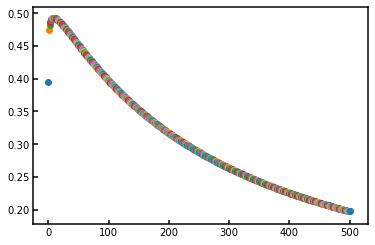

In [5]:
# Prove that the heatmap is actually continuous
kappa = 4.05
sigma = 1.0
half = int(len(pefRange)/2)
inpeF = pefRange[half]
ei = 0
xi = 0
inxF = xfRange[xi]

# Plot first coefficient in phig
for i in range(0, len(pesRange)):
    y = (3. * (np.pi**2) * kappa * sigma) / (4. * ((inpeF*inxF) + (pesRange[i]*(1.-inxF))))
    plt.scatter(pesRange[i], y)
plt.show()

# Plotting second coefficient in phig
for i in range(0, len(pesRange)):
    y = ((1.-inxF) / latS[ei][xi][half][i]) + ((inxF) / latF[ei][xi][half][i])
    plt.scatter(pesRange[i], y)
plt.show()

# Combine and plot
for i in range(0, len(pesRange)):
    z = (3. * (np.pi**2) * kappa * sigma) / (4. * ((inpeF*inxF) + (pesRange[i]*(1.-inxF))))
    y = ((1.-inxF) / latS[ei][xi][half][i]) + ((inxF) / latF[ei][xi][half][i])
    plt.scatter(pesRange[i], y*z)
plt.show()